<h1><a>Data Preparation</a></h1>

<h2><a id="index">Index</a></h2>

[1. Functions](#funcs)

[2. Read Data](#readdata)

[3. Exploratory Data Analysis](#exploredata)

[4. General Preprocessing](#generalpreprocessing)

[5. Data Cleaning and Missing Value Treatment](#missingvaluetreatment)

[6. PD model - Dependent Variable](#pddep)

[7. Divide in Train-Test Sample](#splitd)

[8. Data Preparation](#dataprep)

[9. Export to CSV File](#exportdata)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
# Imports the libraries we need.
sns.set()

<h2><a id="funcs">1. Functions</a></h2>

[Index](#index)

In [2]:
# WoE function for discrete unordered variables
def woe_discrete(df, discrete_variabe_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variabe_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df
# Here we combine all of the operations above in a function.
# The function takes 3 arguments: a dataframe, a string, and a dataframe. The function returns a dataframe as a result.

In [3]:
# Below we define a function that takes 2 arguments: a dataframe and a number.
# The number parameter has a default value of 0.
# This means that if we call the function and omit the number parameter, it will be executed with it having a value of 0.
# The function displays a graph.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    # Turns the values of the column with index 0 to strings, makes an array from these strings,
    # and passes it to variable x.
    y = df_WoE['WoE']
    # Selects a column with label 'WoE' and passes it to variable y.
    plt.figure(figsize=(18, 6))
    # Sets the graph size to width 18 x height 6.
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    # Plots the datapoints with coordiantes variable x on the x-axis and variable y on the y-axis.
    # Sets the marker for each datapoint to a circle, the style line between the points to dashed, and the color to black.
    plt.xlabel(df_WoE.columns[0])
    # Names the x-axis with the name of the column with index 0.
    plt.ylabel('Weight of Evidence')
    # Names the y-axis 'Weight of Evidence'.
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    # Names the grapth 'Weight of Evidence by ' the name of the column with index 0.
    plt.xticks(rotation = rotation_of_x_axis_labels)
    # Rotates the labels of the x-axis a predefined number of degrees.

In [4]:
# WoE function for ordered discrete and continuous variables
def woe_ordered_continuous(df, discrete_variabe_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variabe_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df
# Here we define a function similar to the one above, ...
# ... with one slight difference: we order the results by the values of a different column.
# The function takes 3 arguments: a dataframe, a string, and a dataframe. The function returns a dataframe as a result.

<h2><a id="readdata">2. Read Data</a></h2>

[Index](#index)

In [5]:
# Import Libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

The dataset contains all available data for more than 800,000 consumer loans issued from 2007 to 2015 by Lending Club: a large US peer-to-peer lending company. There are several different versions of this dataset. We have used a version available on kaggle.com. You can find it here: https://www.kaggle.com/datasets/wordsforthewise/lending-club
We divided the data into two periods because we assume that some data are available at the moment when we need to build Expected Loss models, and some data comes from applications after. Later, we investigate whether the applications we have after we built the Probability of Default (PD) model have similar characteristics with the applications we used to build the PD model.

In [6]:
loan_data_backup = pd.read_csv('../Data/loan_data_2007_2014.csv')

In [7]:
loan_data = loan_data_backup.copy()

<h2><a id="exploredata">3. Exploratory Data Analysis</a></h2>

[Index](#index)

In [8]:
pd.options.display.max_columns = None
#pd.options.display.max_rows = None
# Sets the pandas dataframe options to display all columns/ rows.

In [9]:
loan_data.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
loan_data.info()
# Displays column names, complete (non-missing) cases per column, and datatype per column.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

<h2><a id="generalpreprocessing">4. General Preprocessing</a></h2>

[Index](#index)

[4.1 Continuous Variables](#precontvar)

[4.2 Discrete Variables](#prediscvar)

<h3><a id="precontvar">4.1 Continuous Variables</a></h3>

[Top](#generalpreprocessing)

[4.1.1 Employement Length](#emp_length)

[4.1.2 Earliest Credit Line](#earliest_cr_line)

[4.1.3 Term](#term)

[4.1.4 Issue Date](#issue_d_date)

<h4><a id="emp_length">4.1.1 Employement Length</a></h4>

[Top](#precontvar)

In [11]:
loan_data['emp_length'].unique()
# Displays unique values of a column.

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [12]:
# We store the preprocessed ‘employment length’ variable in a new variable called ‘employment length int’,
loan_data['emp_length_int'] = loan_data['emp_length'].str.replace('\+ years', '')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('< 1 year', str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('n/a',  str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' years', '')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' year', '')

In [13]:
# Checks the datatype of a single element of a column.
type(loan_data['emp_length_int'][0])

str

In [14]:
# Transforms the values to numeric.
loan_data['emp_length_int'] = pd.to_numeric(loan_data['emp_length_int'])
# Checks the datatype of a single element of a column.
type(loan_data['emp_length_int'][0])


numpy.float64

<h4><a id="earliest_cr_line">4.1.2 Earliest Credit Line</a></h4>

[Top](#precontvar)

In [15]:
loan_data['earliest_cr_line'].head()

0    Jan-85
1    Apr-99
2    Nov-01
3    Feb-96
4    Jan-96
Name: earliest_cr_line, dtype: object

In [16]:
# Extracts the date and the time from a string variable that is in a given format.
loan_data['earliest_cr_line_date'] = pd.to_datetime(loan_data['earliest_cr_line'], format = '%b-%y')
# Checks the datatype of a single element of a column.
type(loan_data['earliest_cr_line_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [17]:
# Assume we are now in December 2017
# We calculate the difference between two dates in months, turn it to numeric datatype and round it
loan_data['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - 
                                                                loan_data['earliest_cr_line_date']) /
                                                               np.timedelta64(1, 'M')))
loan_data['mths_since_earliest_cr_line'].describe()

count    466256.000000
mean        239.482430
std          93.974829
min        -612.000000
25%         183.000000
50%         225.000000
75%         285.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [18]:
# Display values where it is negative
loan_data.loc[: , ['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']][
    loan_data['mths_since_earliest_cr_line'] < 0]

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-537.0
1770,Sep-68,2068-09-01,-609.0
2799,Sep-64,2064-09-01,-561.0
3282,Sep-67,2067-09-01,-597.0
3359,Feb-65,2065-02-01,-566.0
...,...,...,...
464003,Jan-68,2068-01-01,-601.0
464260,Jul-66,2066-07-01,-583.0
465100,Oct-67,2067-10-01,-598.0
465500,Sep-67,2067-09-01,-597.0


In [19]:
# We set the rows that had negative differences to the maximum value as these were taken in 1900s
loan_data['mths_since_earliest_cr_line'][loan_data['mths_since_earliest_cr_line'] < 0] = (
    loan_data['mths_since_earliest_cr_line'].max())
loan_data['mths_since_earliest_cr_line'].describe()

count    466256.000000
mean        242.385374
std          86.460310
min          73.000000
25%         184.000000
50%         226.000000
75%         285.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

<h4><a id="term">4.1.3 Term</a></h4>

[Top](#precontvar)

In [20]:
loan_data['term'].head()

0     36 months
1     60 months
2     36 months
3     36 months
4     60 months
Name: term, dtype: object

In [21]:
# We remplace a string from a variable with another string, in this case, with an empty strng (i.e. with nothing).
# We turn the result to numeric datatype and save it in another variable.
loan_data['term_int'] = pd.to_numeric(loan_data['term'].str.replace(' months', ''))
loan_data['term_int'].head()

0    36
1    60
2    36
3    36
4    60
Name: term_int, dtype: int64

In [22]:
# Checks the datatype of a single element of a column.
type(loan_data['term_int'][0])

numpy.int64

<h4><a id="issue_d_date">4.1.4 Issue Date</a></h4>

[Top](#precontvar)

In [23]:
# Assume we are now in December 2017
loan_data['issue_d_date'] = pd.to_datetime(loan_data['issue_d'], format = '%b-%y')
# Extracts the date and the time from a string variable that is in a given format.
loan_data['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_data['issue_d_date']) / 
                                                      np.timedelta64(1, 'M')))
# We calculate the difference between two dates in months, turn it to numeric datatype and round it.
# We save the result in a new variable.
loan_data['mths_since_issue_d'].describe()

count    466285.000000
mean         51.255187
std          14.340154
min          36.000000
25%          41.000000
50%          47.000000
75%          57.000000
max         126.000000
Name: mths_since_issue_d, dtype: float64

<h3><a id="prediscvar">4.2 Discrete Variables</a></h3>

[Top](#generalpreprocessing)


We are going to preprocess the following discrete variables: grade, sub_grade, home_ownership, verification_status, loan_status, purpose, addr_state, initial_list_status. Most likely, we are not going to use sub_grade, as it overlaps with grade.


In [24]:
# We create dummy variables from all 8 original independent variables, and save them into a list.
# Note that we are using a particular naming convention for all variables: original variable name, colon, category name.
loan_data_dummies = [pd.get_dummies(loan_data['grade'], prefix = 'grade', prefix_sep = ':'),
                     pd.get_dummies(loan_data['sub_grade'], prefix = 'sub_grade', prefix_sep = ':'),
                     pd.get_dummies(loan_data['home_ownership'], prefix = 'home_ownership', prefix_sep = ':'),
                     pd.get_dummies(loan_data['verification_status'], prefix = 'verification_status', prefix_sep = ':'),
                     pd.get_dummies(loan_data['loan_status'], prefix = 'loan_status', prefix_sep = ':'),
                     pd.get_dummies(loan_data['purpose'], prefix = 'purpose', prefix_sep = ':'),
                     pd.get_dummies(loan_data['addr_state'], prefix = 'addr_state', prefix_sep = ':'),
                     pd.get_dummies(loan_data['initial_list_status'], prefix = 'initial_list_status', prefix_sep = ':')]

In [25]:
# We concatenate the dummy variables and this turns them into a dataframe.
loan_data_dummies = pd.concat(loan_data_dummies, axis = 1)

In [26]:
# Concatenates two dataframes.
# Here we concatenate the dataframe with original data with the dataframe with dummy variables, along the columns. 
loan_data = pd.concat([loan_data, loan_data_dummies], axis = 1)

<h2><a id="missingvaluetreatment">5. Data Cleaning and Missing Value Treatment</a></h2>

[Index](#index)

In [27]:
# Calculate null values
null_values = loan_data.isnull().sum()
null_values[null_values>0]

emp_title                       27588
emp_length                      21008
annual_inc                          4
desc                           340302
title                              20
delinq_2yrs                        29
earliest_cr_line                   29
inq_last_6mths                     29
mths_since_last_delinq         250351
mths_since_last_record         403647
open_acc                           29
pub_rec                            29
revol_util                        340
total_acc                          29
last_pymnt_d                      376
next_pymnt_d                   227214
last_credit_pull_d                 42
collections_12_mths_ex_med        145
mths_since_last_major_derog    367311
annual_inc_joint               466285
dti_joint                      466285
verification_status_joint      466285
acc_now_delinq                     29
tot_coll_amt                    70276
tot_cur_bal                     70276
open_acc_6m                    466285
open_il_6m  

In [28]:
# 'Total revolving high credit/ credit limit', so it makes sense that the missing values are equal to funded_amnt.
loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'], inplace=True)
loan_data['total_rev_hi_lim'].isnull().sum()

0

In [29]:
# We fill the missing values with the mean value of the non-missing values.
loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean(), inplace=True)
loan_data['annual_inc'].isnull().sum()

0

In [30]:
# We fill the missing values with zeroes.
loan_data['mths_since_earliest_cr_line'].fillna(0, inplace=True)
loan_data['acc_now_delinq'].fillna(0, inplace=True)
loan_data['total_acc'].fillna(0, inplace=True)
loan_data['pub_rec'].fillna(0, inplace=True)
loan_data['open_acc'].fillna(0, inplace=True)
loan_data['inq_last_6mths'].fillna(0, inplace=True)
loan_data['delinq_2yrs'].fillna(0, inplace=True)
loan_data['emp_length_int'].fillna(0, inplace=True)

In [31]:
# Calculate null values
null_values = loan_data.isnull().sum()
null_values[null_values>0]

emp_title                       27588
emp_length                      21008
desc                           340302
title                              20
earliest_cr_line                   29
mths_since_last_delinq         250351
mths_since_last_record         403647
revol_util                        340
last_pymnt_d                      376
next_pymnt_d                   227214
last_credit_pull_d                 42
collections_12_mths_ex_med        145
mths_since_last_major_derog    367311
annual_inc_joint               466285
dti_joint                      466285
verification_status_joint      466285
tot_coll_amt                    70276
tot_cur_bal                     70276
open_acc_6m                    466285
open_il_6m                     466285
open_il_12m                    466285
open_il_24m                    466285
mths_since_rcnt_il             466285
total_bal_il                   466285
il_util                        466285
open_rv_12m                    466285
open_rv_24m 

<h2><a id="pddep">6. PD model - Dependent Variable</a></h2>

[Index](#index)

In [32]:
# Displays unique values of a column.
loan_data['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [33]:
# Calculates the number of observations for each unique value of a variable.
loan_data['loan_status'].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [34]:
loan_data['loan_status'].value_counts(normalize=True)
# We divide the number of observations for each unique value of a variable by the total number of observations.
# Thus, we get the proportion of observations for each unique value of a variable.

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

In [35]:
# Good/ Bad Definition
loan_data['good_bad'] = np.where(loan_data['loan_status'].isin(['Charged Off', 'Default',
                                                       'Does not meet the credit policy. Status:Charged Off',
                                                       'Late (31-120 days)']), 0, 1)
loan_data['good_bad'].value_counts(normalize=True)

1    0.890693
0    0.109307
Name: good_bad, dtype: float64

<h2><a id="splitd">7. Divide in Train-Test Sample</a></h2>

[Index](#index)

In [36]:
# Imports the libraries we need.
from sklearn.model_selection import train_test_split

In [37]:
# Test size: 20%
loan_data_inputs_train, loan_data_inputs_test, loan_data_targets_train, loan_data_targets_test = train_test_split(
    loan_data.drop('good_bad', axis = 1), loan_data['good_bad'], test_size = 0.2, random_state = 42)

In [38]:
# Displays the size of the dataframe.
print(f"Train Sample X: {loan_data_inputs_train.shape}")
print(f"Train Sample y: {loan_data_targets_train.shape}")
print(f"Test Sample X: {loan_data_inputs_test.shape}")
print(f"Test Sample y: {loan_data_targets_test.shape}")

Train Sample X: (373028, 207)
Train Sample y: (373028,)
Test Sample X: (93257, 207)
Test Sample y: (93257,)


<h2><a id="dataprep">8. Data Preparation</a></h2>

[Index](#index)

[8.1 Discrete Variables](#discretewoewoe)

[8.2 Continuous Variables](#continuouswoe)

In [39]:
#####
df_inputs_prepr = loan_data_inputs_test
df_targets_prepr = loan_data_targets_test

<h3><a id="discretewoewoe">8.1 Discrete Variables</a></h3>

[Top](#dataprep)

[8.1.1 Grade](#gradewoe)

[8.1.2 Home Ownership](#homeownershipwoe)

[8.1.3 Address State](#addr_statewoe)

[8.1.4 Verification Status](#verifstatuswoe)

[8.1.5 Purpose](#purposewoe)

[8.1.6 Initial List Status](#initialliststatuswoe)

<h4><a id="gradewoe">8.1.1 Grade</a></h4>

[Top](#discretewoewoe)

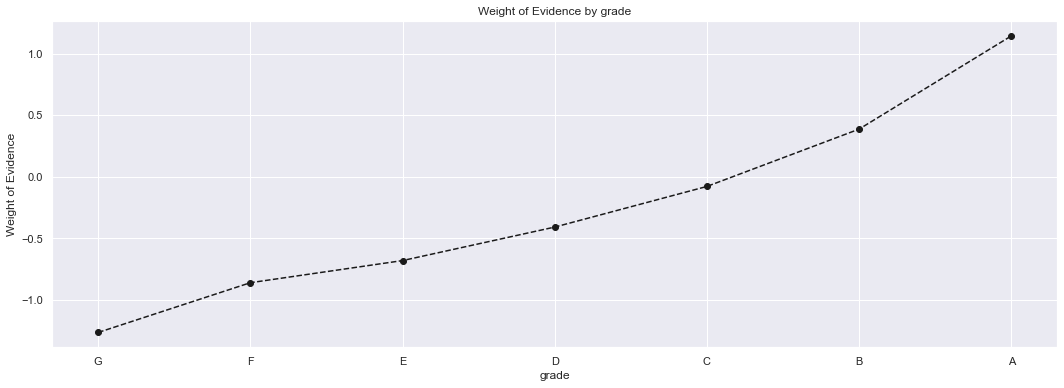

In [40]:
# 'grade'
df_temp = woe_discrete(df_inputs_prepr, 'grade', df_targets_prepr)
plot_by_woe(df_temp)

<h4><a id="homeownershipwoe">8.1.2 Home Ownership</a></h4>

[Top](#discretewoewoe)

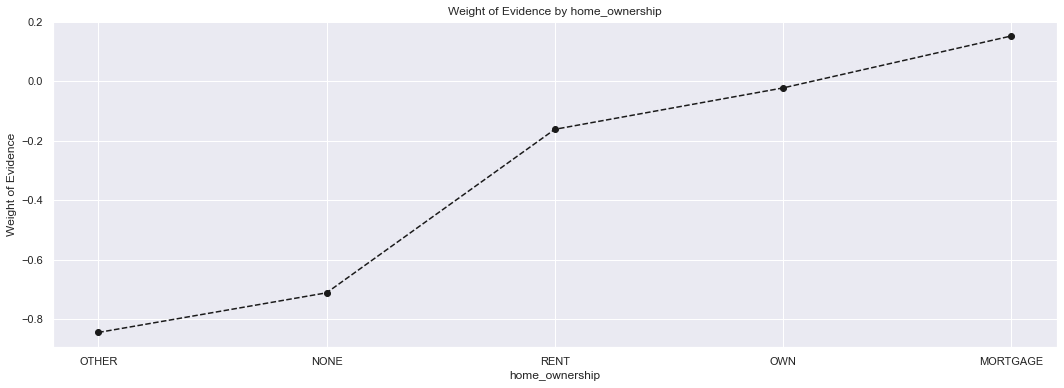

In [41]:
# 'home_ownership'
df_temp = woe_discrete(df_inputs_prepr, 'home_ownership', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp)

In [42]:
# There are many categories with very few observations and many categories with very different "good" %.
# Therefore, we create a new discrete variable where we combine some of the categories.
# 'OTHERS' and 'NONE' are riskiest but are very few. 'RENT' is the next riskiest.
# 'ANY' are least risky but are too few. Conceptually, they belong to the same category. 
# Also, their inclusion would not change anything.
# We combine them in one category, 'RENT_OTHER_NONE_ANY'.
# We end up with 3 categories: 'RENT_OTHER_NONE_ANY', 'OWN', 'MORTGAGE'.
df_inputs_prepr['home_ownership:RENT_OTHER_NONE_ANY'] = sum([df_inputs_prepr['home_ownership:RENT'],
                                                             df_inputs_prepr['home_ownership:OTHER'], 
                                                             df_inputs_prepr['home_ownership:NONE'], 
                                                             df_inputs_prepr['home_ownership:ANY']])
# 'RENT_OTHER_NONE_ANY' will be the reference category.

<h4><a id="addr_statewoe">8.1.3 Address State</a></h4>

[Top](#discretewoewoe)

In [43]:
# 'addr_state'
df_inputs_prepr['addr_state'].unique()

array(['CA', 'IN', 'AZ', 'MI', 'PA', 'MO', 'CT', 'IL', 'SC', 'VA', 'NY',
       'FL', 'TX', 'NC', 'NM', 'NJ', 'KY', 'DE', 'OK', 'CO', 'OH', 'GA',
       'LA', 'WA', 'AL', 'TN', 'MD', 'NV', 'MN', 'RI', 'NH', 'MA', 'MS',
       'UT', 'WV', 'HI', 'KS', 'OR', 'WY', 'WI', 'AK', 'DC', 'AR', 'MT',
       'SD', 'VT', 'IA', 'ID', 'ME', 'NE'], dtype=object)

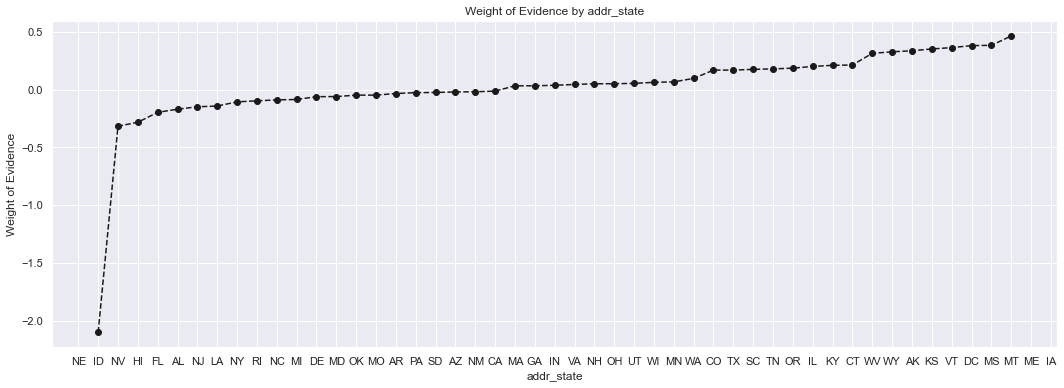

In [44]:
df_temp = woe_discrete(df_inputs_prepr, 'addr_state', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp)

In [45]:
if ['addr_state:ND'] in df_inputs_prepr.columns.values:
    pass
else:
    df_inputs_prepr['addr_state:ND'] = 0

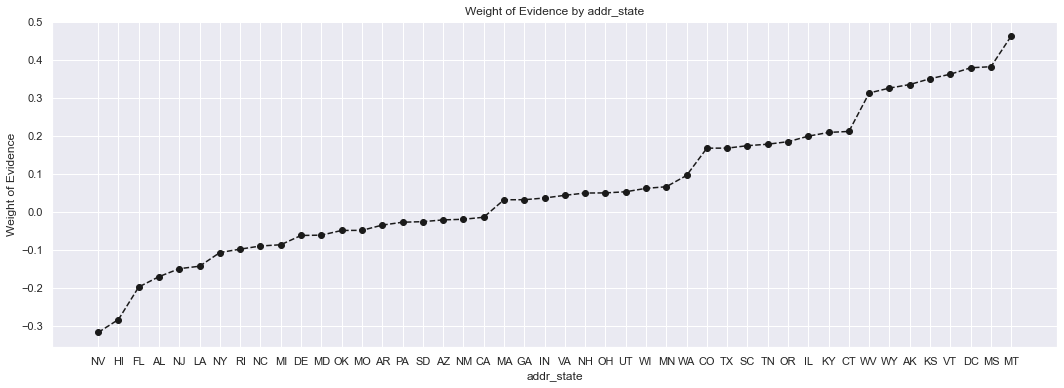

In [46]:
plot_by_woe(df_temp.iloc[2: -2, : ])
# We plot the weight of evidence values.

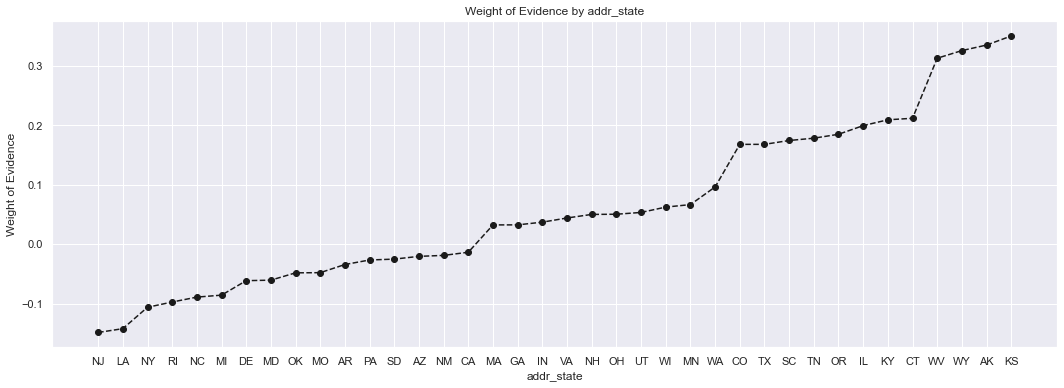

In [47]:
plot_by_woe(df_temp.iloc[6: -6, : ])
# We plot the weight of evidence values.

In [48]:
# We create the following categories:
# 'ND' 'NE' 'IA' NV' 'FL' 'HI' 'AL'
# 'NM' 'VA'
# 'NY'
# 'OK' 'TN' 'MO' 'LA' 'MD' 'NC'
# 'CA'
# 'UT' 'KY' 'AZ' 'NJ'
# 'AR' 'MI' 'PA' 'OH' 'MN'
# 'RI' 'MA' 'DE' 'SD' 'IN'
# 'GA' 'WA' 'OR'
# 'WI' 'MT'
# 'TX'
# 'IL' 'CT'
# 'KS' 'SC' 'CO' 'VT' 'AK' 'MS'
# 'WV' 'NH' 'WY' 'DC' 'ME' 'ID'

# 'IA_NV_HI_ID_AL_FL' will be the reference category.

df_inputs_prepr['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([df_inputs_prepr['addr_state:ND'], 
                                                          df_inputs_prepr['addr_state:NE'], 
                                                          df_inputs_prepr['addr_state:IA'],
                                                          df_inputs_prepr['addr_state:NV'],
                                                          df_inputs_prepr['addr_state:FL'], 
                                                          df_inputs_prepr['addr_state:HI'],
                                                          df_inputs_prepr['addr_state:AL']])

df_inputs_prepr['addr_state:NM_VA'] = sum([df_inputs_prepr['addr_state:NM'], df_inputs_prepr['addr_state:VA']])

df_inputs_prepr['addr_state:OK_TN_MO_LA_MD_NC'] = sum([df_inputs_prepr['addr_state:OK'], df_inputs_prepr['addr_state:TN'],
                                              df_inputs_prepr['addr_state:MO'], df_inputs_prepr['addr_state:LA'],
                                              df_inputs_prepr['addr_state:MD'], df_inputs_prepr['addr_state:NC']])

df_inputs_prepr['addr_state:UT_KY_AZ_NJ'] = sum([df_inputs_prepr['addr_state:UT'], df_inputs_prepr['addr_state:KY'],
                                              df_inputs_prepr['addr_state:AZ'], df_inputs_prepr['addr_state:NJ']])

df_inputs_prepr['addr_state:AR_MI_PA_OH_MN'] = sum([df_inputs_prepr['addr_state:AR'], df_inputs_prepr['addr_state:MI'],
                                              df_inputs_prepr['addr_state:PA'], df_inputs_prepr['addr_state:OH'],
                                              df_inputs_prepr['addr_state:MN']])

df_inputs_prepr['addr_state:RI_MA_DE_SD_IN'] = sum([df_inputs_prepr['addr_state:RI'], df_inputs_prepr['addr_state:MA'],
                                              df_inputs_prepr['addr_state:DE'], df_inputs_prepr['addr_state:SD'],
                                              df_inputs_prepr['addr_state:IN']])

df_inputs_prepr['addr_state:GA_WA_OR'] = sum([df_inputs_prepr['addr_state:GA'], df_inputs_prepr['addr_state:WA'],
                                              df_inputs_prepr['addr_state:OR']])

df_inputs_prepr['addr_state:WI_MT'] = sum([df_inputs_prepr['addr_state:WI'], df_inputs_prepr['addr_state:MT']])

df_inputs_prepr['addr_state:IL_CT'] = sum([df_inputs_prepr['addr_state:IL'], df_inputs_prepr['addr_state:CT']])

df_inputs_prepr['addr_state:KS_SC_CO_VT_AK_MS'] = sum([df_inputs_prepr['addr_state:KS'], df_inputs_prepr['addr_state:SC'],
                                              df_inputs_prepr['addr_state:CO'], df_inputs_prepr['addr_state:VT'],
                                              df_inputs_prepr['addr_state:AK'], df_inputs_prepr['addr_state:MS']])

df_inputs_prepr['addr_state:WV_NH_WY_DC_ME_ID'] = sum([df_inputs_prepr['addr_state:WV'], df_inputs_prepr['addr_state:NH'],
                                              df_inputs_prepr['addr_state:WY'], df_inputs_prepr['addr_state:DC'],
                                              df_inputs_prepr['addr_state:ME'], df_inputs_prepr['addr_state:ID']])

<h4><a id="verifstatuswoe">8.1.4 Verification Status</a></h4>

[Top](#discretewoewoe)

### Preprocessing Discrete Variables: Homework

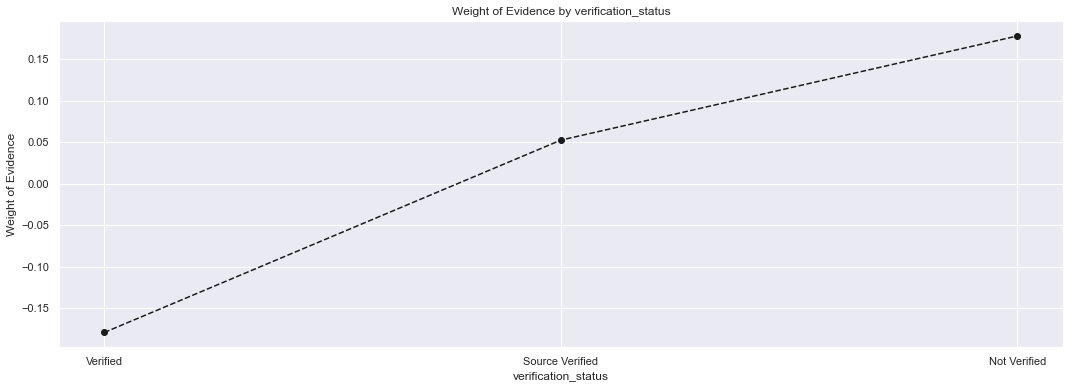

In [49]:
# 'verification_status'
df_temp = woe_discrete(df_inputs_prepr, 'verification_status', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp)

<h4><a id="purposewoe">8.1.5 Purpose</a></h4>

[Top](#discretewoewoe)

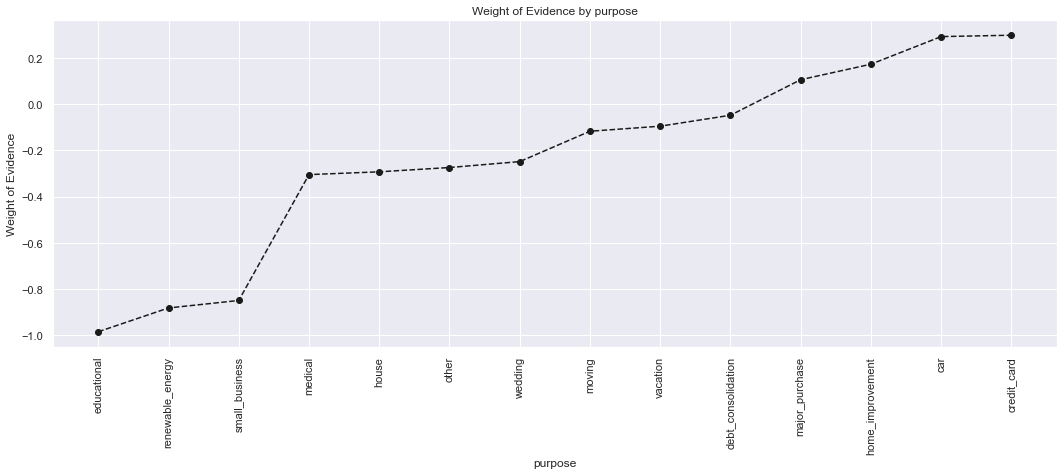

In [50]:
# 'purpose'
df_temp = woe_discrete(df_inputs_prepr, 'purpose', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [51]:
# We combine 'educational', 'small_business', 'wedding', 'renewable_energy', 'moving',
# 'house' in one category: 'educ__sm_b__wedd__ren_en__mov__house'.
# We combine 'other', 'medical', 'vacation' in one category: 'oth__med__vacation'.
# We combine 'major_purchase', 'car', 'home_improvement' in one category: 'major_purch__car__home_impr'.
# We leave 'debt_consolidtion' in a separate category.
# We leave 'credit_card' in a separate category.
# 'educ__sm_b__wedd__ren_en__mov__house' will be the reference category.
df_inputs_prepr['purpose:educ__sm_b__wedd__ren_en__mov__house'] = sum([df_inputs_prepr['purpose:educational'],
                                                                       df_inputs_prepr['purpose:small_business'], 
                                                                       df_inputs_prepr['purpose:wedding'],
                                                                       df_inputs_prepr['purpose:renewable_energy'], 
                                                                       df_inputs_prepr['purpose:moving'], 
                                                                       df_inputs_prepr['purpose:house']])
df_inputs_prepr['purpose:oth__med__vacation'] = sum([df_inputs_prepr['purpose:other'],
                                                     df_inputs_prepr['purpose:medical'],
                                                     df_inputs_prepr['purpose:vacation']])
df_inputs_prepr['purpose:major_purch__car__home_impr'] = sum([df_inputs_prepr['purpose:major_purchase'],
                                                              df_inputs_prepr['purpose:car'],
                                                              df_inputs_prepr['purpose:home_improvement']])

<h4><a id="initialliststatuswoe">8.1.6 Initial List Status</a></h4>

[Top](#discretewoewoe)

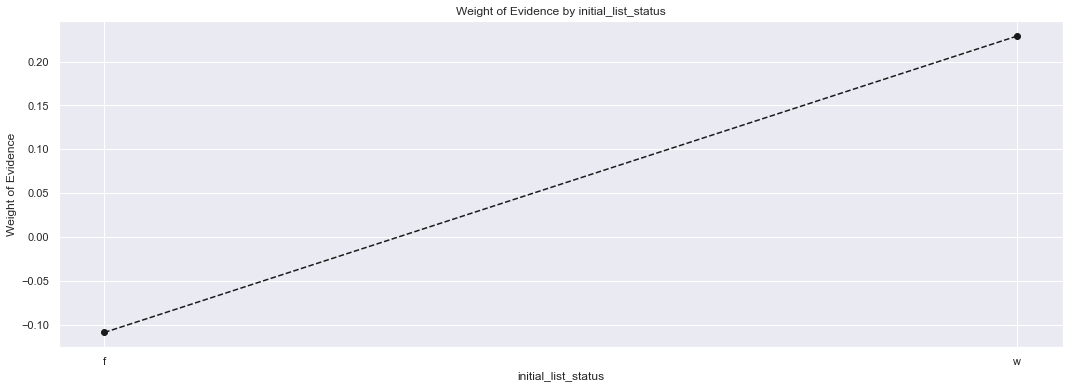

In [52]:
# 'initial_list_status'
df_temp = woe_discrete(df_inputs_prepr, 'initial_list_status', df_targets_prepr)
plot_by_woe(df_temp)

<h3><a id="continuouswoe">8.2 Continuous Variables</a></h3>

[Top](#dataprep)

[8.2.1 Term Int](#term_int_woe)

[8.2.2 Employment Lenght](#employmentlenght_woe)

[8.2.3 Months Since Issue](#monthssinceissued_woe)

[8.2.4 Interest Rate Factor](#int_rate_factor_woe)

[8.2.5 Funded Amount Factor](#funded_amnt_factor_woe)

[8.2.6 Months Since Last Credit Line](#mths_since_earliest_cr_line_factor_woe)

[8.2.7 Deliquency in Last 2 Years](#delinq_2yrs_woe)

[8.2.8 Credit Inquiries in Last 6 months](#inq_last_6mths_woe)

[8.2.9 Open Accounts](#open_acc_woe)

[8.2.10 Derogatory Public Records (bankruptcy filings, tax liens, or judgments](#pub_rec_woe)

[8.2.11 Total Accounts](#total_acc_woe)

[8.2.12 Accounts Deliquents](#acc_now_delinq_woe)

[8.2.13 Total Revolving Credit Limit](#total_rev_hi_lim_woe)

[8.2.14 Installment Factor](#installment_factor_woe)

[8.2.15 Annual Income](#annual_inc_factor_woe)

[8.2.16 Months Since Last Delinquency](#mths_since_last_delinq_woe)

[8.2.17 Debt to Income Ratio](#dti_factor_woe)

[8.2.18 Months Since Last Record](#mths_since_last_record_woe)

<h4><a id="term_int_woe">8.2.1 Term Int</a></h4>

[Top](#continuouswoe)

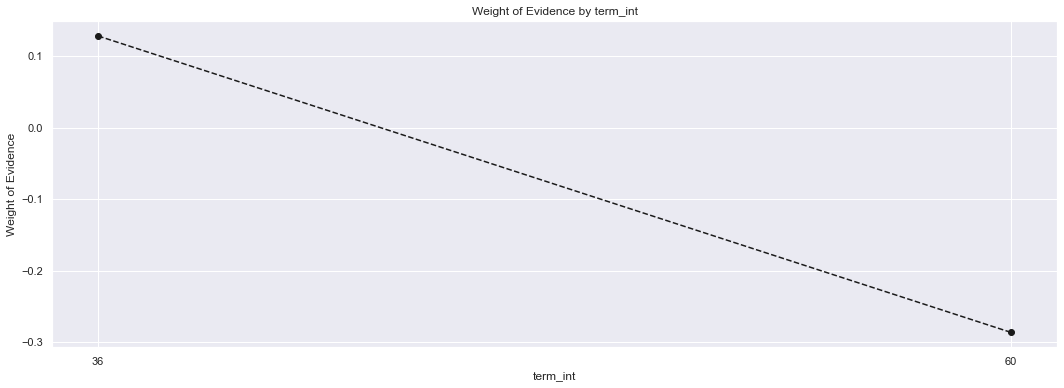

In [53]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'term_int', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp)

In [54]:
# Leave as is.
# '60' will be the reference category.
df_inputs_prepr['term:36'] = np.where((df_inputs_prepr['term_int'] == 36), 1, 0)
df_inputs_prepr['term:60'] = np.where((df_inputs_prepr['term_int'] == 60), 1, 0)

<h4><a id="employmentlenght_woe">8.2.2 Employment Length</a></h4>

[Top](#continuouswoe)

In [55]:
# emp_length_int
df_inputs_prepr['emp_length_int'].unique()
# Has only 11 levels: from 0 to 10. Hence, we turn it into a factor with 11 levels.

array([ 0., 10.,  1.,  2.,  9.,  3.,  6.,  4.,  7.,  8.,  5.])

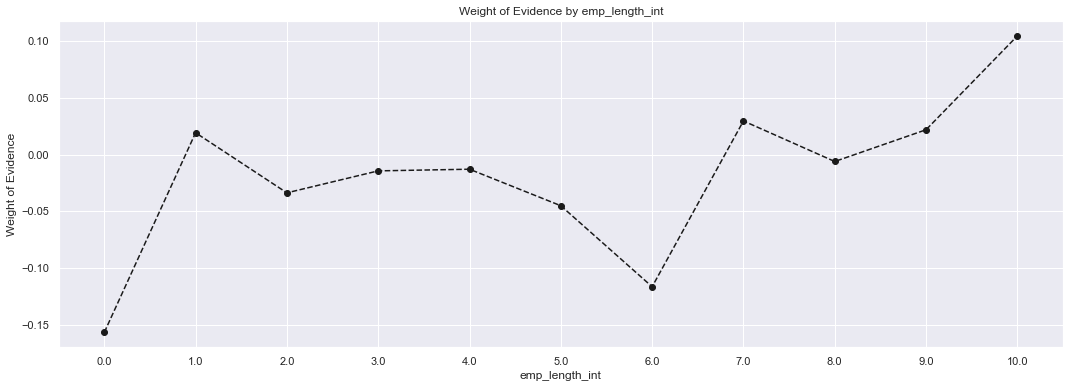

In [56]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'emp_length_int', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp)

In [57]:
# We create the following categories: '0', '1', '2 - 4', '5 - 6', '7 - 9', '10'
# '0' will be the reference category
df_inputs_prepr['emp_length:0'] = np.where(df_inputs_prepr['emp_length_int'].isin([0]), 1, 0)
df_inputs_prepr['emp_length:1'] = np.where(df_inputs_prepr['emp_length_int'].isin([1]), 1, 0)
df_inputs_prepr['emp_length:2-4'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(2, 5)), 1, 0)
df_inputs_prepr['emp_length:5-6'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(5, 7)), 1, 0)
df_inputs_prepr['emp_length:7-9'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(7, 10)), 1, 0)
df_inputs_prepr['emp_length:10'] = np.where(df_inputs_prepr['emp_length_int'].isin([10]), 1, 0)

<h4><a id="monthssinceissued_woe">8.2.3 Months Since Issue</a></h4>

[Top](#continuouswoe)

In [58]:
df_inputs_prepr['mths_since_issue_d'].unique()

array([ 41.,  38.,  66.,  37.,  58.,  50.,  86.,  51.,  48.,  59.,  72.,
        77.,  47.,  46.,  56.,  55., 119.,  63., 102.,  39.,  53.,  40.,
        52.,  43.,  49.,  57.,  45.,  36.,  54.,  74.,  44.,  73., 103.,
        70.,  95.,  89.,  68.,  82.,  71.,  76., 104.,  65.,  80.,  91.,
        75.,  67.,  42.,  61.,  64.,  60.,  85.,  88., 110.,  96.,  78.,
        83.,  69.,  90.,  62., 108.,  79.,  92., 118.,  99.,  81., 115.,
        97., 114., 116., 100.,  93., 117., 106., 124., 101., 125.,  87.,
        84.,  94., 105., 109.,  98., 107., 112., 113., 122., 111., 120.,
       121., 123., 126.])

In [59]:
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_inputs_prepr['mths_since_issue_d_factor'] = pd.cut(df_inputs_prepr['mths_since_issue_d'], 50)
df_inputs_prepr['mths_since_issue_d_factor']

362514     (39.6, 41.4]
288564     (37.8, 39.6]
213591     (64.8, 66.6]
263083    (35.91, 37.8]
165001     (57.6, 59.4]
              ...      
115        (70.2, 72.0]
296284     (37.8, 39.6]
61777      (48.6, 50.4]
91763      (50.4, 52.2]
167512     (57.6, 59.4]
Name: mths_since_issue_d_factor, Length: 93257, dtype: category
Categories (50, interval[float64, right]): [(35.91, 37.8] < (37.8, 39.6] < (39.6, 41.4] < (41.4, 43.2] ... (118.8, 120.6] < (120.6, 122.4] < (122.4, 124.2] < (124.2, 126.0]]

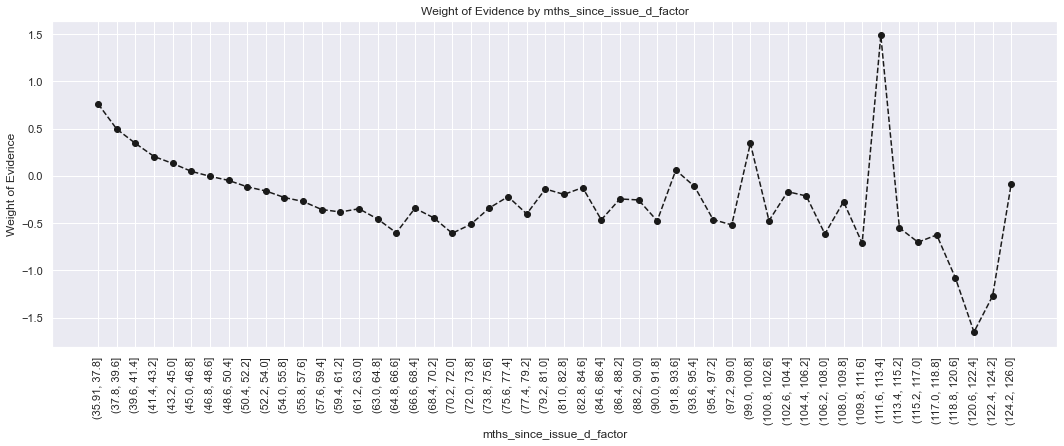

In [60]:
# mths_since_issue_d
df_temp = woe_ordered_continuous(df_inputs_prepr, 'mths_since_issue_d_factor', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

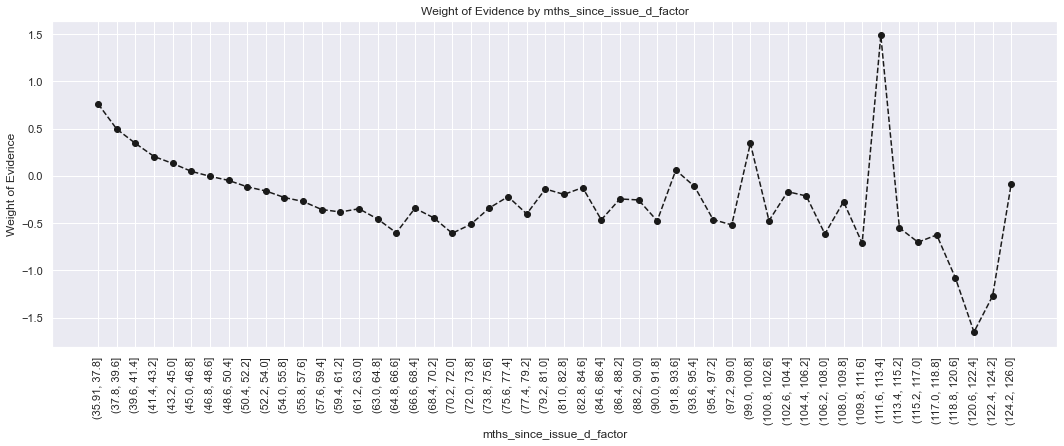

In [61]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values, rotating the labels 90 degrees.

In [62]:
# We create the following categories:
# < 38, 38 - 39, 40 - 41, 42 - 48, 49 - 52, 53 - 64, 65 - 84, > 84.
df_inputs_prepr['mths_since_issue_d:<38'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38)), 1, 0)
df_inputs_prepr['mths_since_issue_d:38-39'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38, 40)), 1, 0)
df_inputs_prepr['mths_since_issue_d:40-41'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(40, 42)), 1, 0)
df_inputs_prepr['mths_since_issue_d:42-48'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(42, 49)), 1, 0)
df_inputs_prepr['mths_since_issue_d:49-52'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(49, 53)), 1, 0)
df_inputs_prepr['mths_since_issue_d:53-64'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(53, 65)), 1, 0)
df_inputs_prepr['mths_since_issue_d:65-84'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(65, 85)), 1, 0)
df_inputs_prepr['mths_since_issue_d:>84'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(
    range(85, int(df_inputs_prepr['mths_since_issue_d'].max()))), 1, 0)

<h4><a id="int_rate_factor_woe">8.2.4 Interest Rate Factor</a></h4>

[Top](#continuouswoe)

In [63]:
# int_rate
df_inputs_prepr['int_rate_factor'] = pd.cut(df_inputs_prepr['int_rate'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.

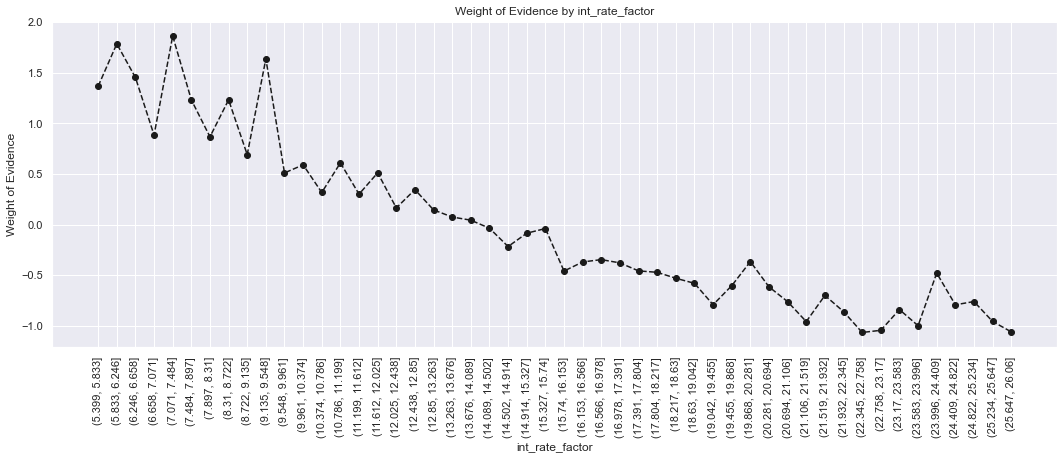

In [64]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'int_rate_factor', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [65]:
df_inputs_prepr['int_rate:<9.548'] = np.where((df_inputs_prepr['int_rate'] <= 9.548), 1, 0)
df_inputs_prepr['int_rate:9.548-12.025'] = np.where((df_inputs_prepr['int_rate'] > 9.548) & 
                                                    (df_inputs_prepr['int_rate'] <= 12.025), 1, 0)
df_inputs_prepr['int_rate:12.025-15.74'] = np.where((df_inputs_prepr['int_rate'] > 12.025) & 
                                                    (df_inputs_prepr['int_rate'] <= 15.74), 1, 0)
df_inputs_prepr['int_rate:15.74-20.281'] = np.where((df_inputs_prepr['int_rate'] > 15.74) & 
                                                    (df_inputs_prepr['int_rate'] <= 20.281), 1, 0)
df_inputs_prepr['int_rate:>20.281'] = np.where((df_inputs_prepr['int_rate'] > 20.281), 1, 0)

<h4><a id="funded_amnt_factor_woe">8.2.5 Funded Amount Factor</a></h4>

[Top](#continuouswoe)

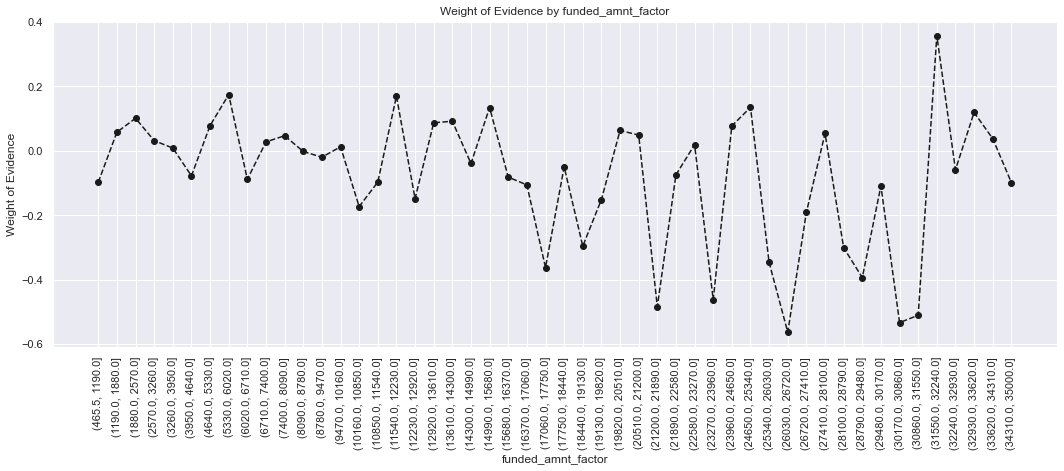

In [66]:
# funded_amnt
df_inputs_prepr['funded_amnt_factor'] = pd.cut(df_inputs_prepr['funded_amnt'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'funded_amnt_factor', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

<h4><a id="mths_since_earliest_cr_line_factor_woe">8.2.6 Months Since Last Credit Line</a></h4>

[Top](#continuouswoe)

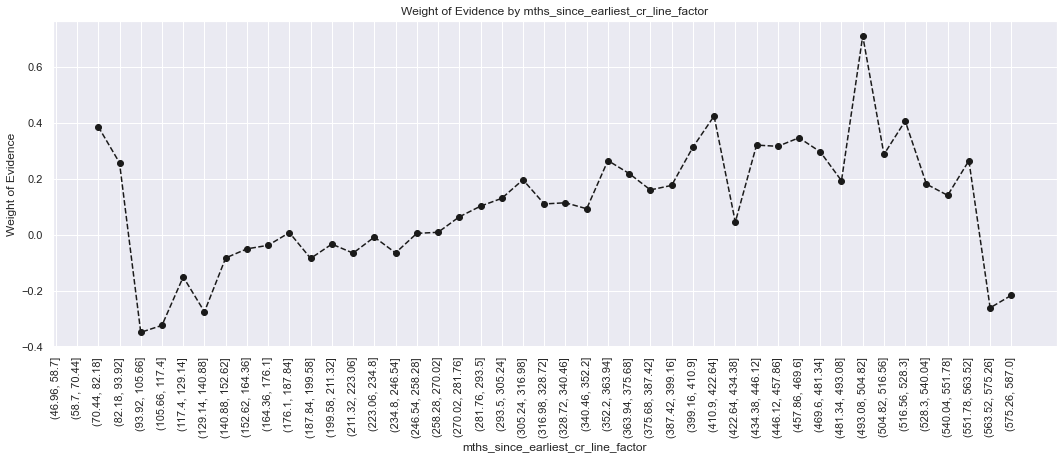

In [67]:
# mths_since_earliest_cr_line
df_inputs_prepr['mths_since_earliest_cr_line_factor'] = pd.cut(df_inputs_prepr['mths_since_earliest_cr_line'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'mths_since_earliest_cr_line_factor', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [68]:
# We create the following categories:
# < 140, # 141 - 164, # 165 - 247, # 248 - 270, # 271 - 352, # > 352
df_inputs_prepr['mths_since_earliest_cr_line:<140'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(
    range(140)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:141-164'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(
    range(140, 165)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:165-247'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(
    range(165, 248)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:248-270'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(
    range(248, 271)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:271-352'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(
    range(271, 353)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:>352'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(
    range(353, int(df_inputs_prepr['mths_since_earliest_cr_line'].max()))), 1, 0)

<h4><a id="delinq_2yrs_woe">8.2.7 Deliquency in Last 2 Years</a></h4>

[Top](#continuouswoe)

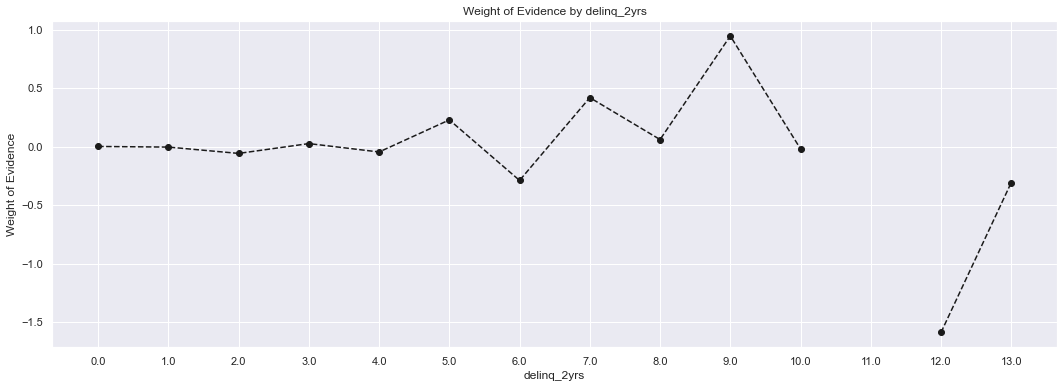

In [69]:
# delinq_2yrs
df_temp = woe_ordered_continuous(df_inputs_prepr, 'delinq_2yrs', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp)

In [70]:
# Categories: 0, 1-3, >=4
df_inputs_prepr['delinq_2yrs:0'] = np.where((df_inputs_prepr['delinq_2yrs'] == 0), 1, 0)
df_inputs_prepr['delinq_2yrs:1-3'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 1) & 
                                              (df_inputs_prepr['delinq_2yrs'] <= 3), 1, 0)
df_inputs_prepr['delinq_2yrs:>=4'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 9), 1, 0)

<h4><a id="inq_last_6mths_woe">8.2.8 Credit Inquiries in Last 6 months</a></h4>

[Top](#continuouswoe)

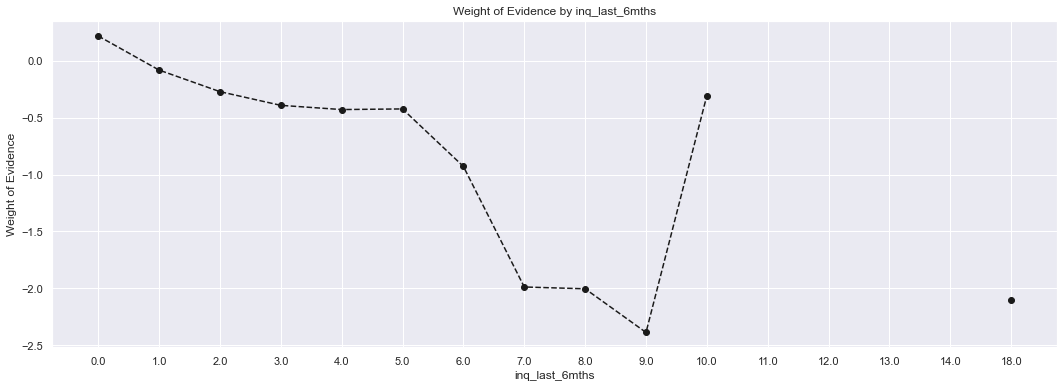

In [71]:
# inq_last_6mths
df_temp = woe_ordered_continuous(df_inputs_prepr, 'inq_last_6mths', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp)

In [72]:
# Categories: 0, 1 - 2, 3 - 6, > 6
df_inputs_prepr['inq_last_6mths:0'] = np.where((df_inputs_prepr['inq_last_6mths'] == 0), 1, 0)
df_inputs_prepr['inq_last_6mths:1-2'] = np.where((df_inputs_prepr['inq_last_6mths'] >= 1) & 
                                                 (df_inputs_prepr['inq_last_6mths'] <= 2), 1, 0)
df_inputs_prepr['inq_last_6mths:3-6'] = np.where((df_inputs_prepr['inq_last_6mths'] >= 3) & 
                                                 (df_inputs_prepr['inq_last_6mths'] <= 6), 1, 0)
df_inputs_prepr['inq_last_6mths:>6'] = np.where((df_inputs_prepr['inq_last_6mths'] > 6), 1, 0)

<h4><a id="open_acc_woe">8.2.9 Open Accounts</a></h4>

[Top](#continuouswoe)

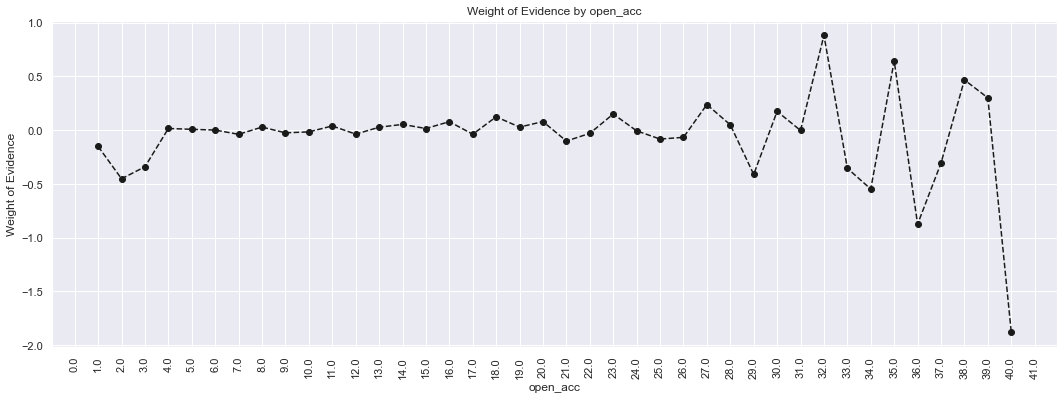

In [73]:
# open_acc
df_temp = woe_ordered_continuous(df_inputs_prepr, 'open_acc', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [74]:
# Categories: '0', '1-3', '4-12', '13-17', '18-22', '23-25', '26-30', '>30'
df_inputs_prepr['open_acc:0'] = np.where((df_inputs_prepr['open_acc'] == 0), 1, 0)
df_inputs_prepr['open_acc:1-3'] = np.where((df_inputs_prepr['open_acc'] >= 1) & (df_inputs_prepr['open_acc'] <= 3), 1, 0)
df_inputs_prepr['open_acc:4-12'] = np.where((df_inputs_prepr['open_acc'] >= 4) & 
                                            (df_inputs_prepr['open_acc'] <= 12), 1, 0)
df_inputs_prepr['open_acc:13-17'] = np.where((df_inputs_prepr['open_acc'] >= 13) & 
                                             (df_inputs_prepr['open_acc'] <= 17), 1, 0)
df_inputs_prepr['open_acc:18-22'] = np.where((df_inputs_prepr['open_acc'] >= 18) & 
                                             (df_inputs_prepr['open_acc'] <= 22), 1, 0)
df_inputs_prepr['open_acc:23-25'] = np.where((df_inputs_prepr['open_acc'] >= 23) & 
                                             (df_inputs_prepr['open_acc'] <= 25), 1, 0)
df_inputs_prepr['open_acc:26-30'] = np.where((df_inputs_prepr['open_acc'] >= 26) & 
                                             (df_inputs_prepr['open_acc'] <= 30), 1, 0)
df_inputs_prepr['open_acc:>=31'] = np.where((df_inputs_prepr['open_acc'] >= 31), 1, 0)

<h4><a id="pub_rec_woe">8.2.10 Derogatory Public Records (bankruptcy filings, tax liens, or judgments)</a></h4>

[Top](#continuouswoe)

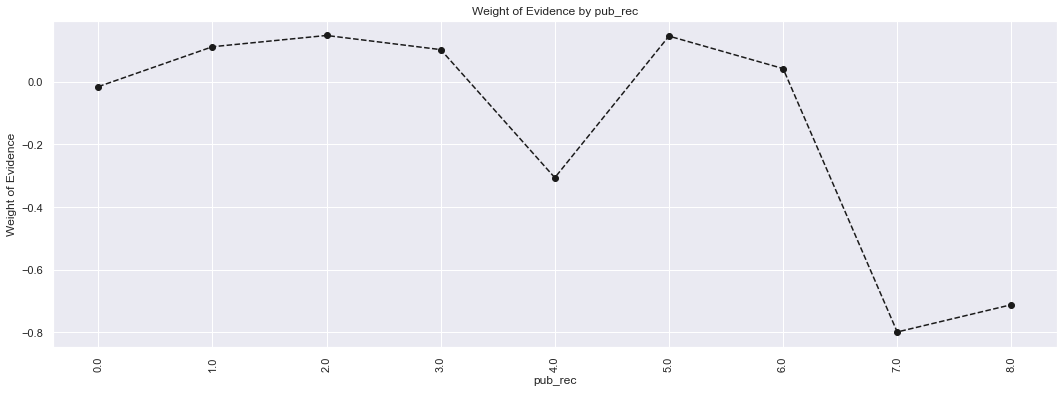

In [75]:
# pub_rec
df_temp = woe_ordered_continuous(df_inputs_prepr, 'pub_rec', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [76]:
# Categories '0-2', '3-4', '>=5'
df_inputs_prepr['pub_rec:0-2'] = np.where((df_inputs_prepr['pub_rec'] >= 0) & (df_inputs_prepr['pub_rec'] <= 2), 1, 0)
df_inputs_prepr['pub_rec:3-4'] = np.where((df_inputs_prepr['pub_rec'] >= 3) & (df_inputs_prepr['pub_rec'] <= 4), 1, 0)
df_inputs_prepr['pub_rec:>=5'] = np.where((df_inputs_prepr['pub_rec'] >= 5), 1, 0)

<h4><a id="total_acc_woe">8.2.11 Total Accounts</a></h4>

[Top](#continuouswoe)

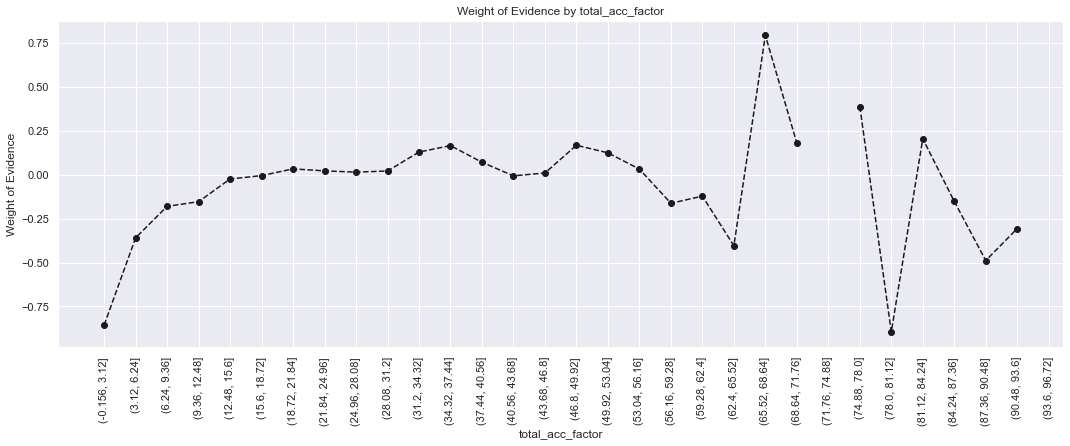

In [77]:
# total_acc
df_inputs_prepr['total_acc_factor'] = pd.cut(df_inputs_prepr['total_acc'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'total_acc_factor', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [78]:
# Categories: '<=27', '28-51', '>51'
df_inputs_prepr['total_acc:<=27'] = np.where((df_inputs_prepr['total_acc'] <= 27), 1, 0)
df_inputs_prepr['total_acc:28-51'] = np.where((df_inputs_prepr['total_acc'] >= 28) & 
                                              (df_inputs_prepr['total_acc'] <= 51), 1, 0)
df_inputs_prepr['total_acc:>=52'] = np.where((df_inputs_prepr['total_acc'] >= 52), 1, 0)

<h4><a id="acc_now_delinq_woe">8.2.12 Accounts Deliquents</a></h4>

[Top](#continuouswoe)

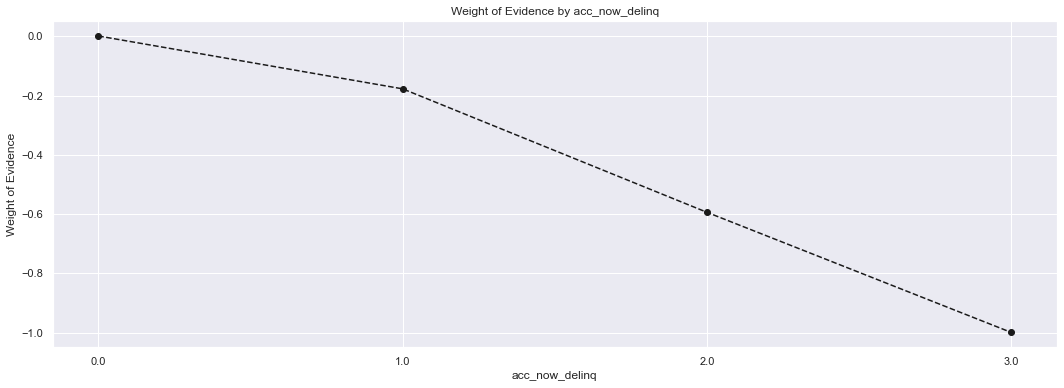

In [79]:
# acc_now_delinq
df_temp = woe_ordered_continuous(df_inputs_prepr, 'acc_now_delinq', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp)

In [80]:
# Categories: '0', '>=1'
df_inputs_prepr['acc_now_delinq:0'] = np.where((df_inputs_prepr['acc_now_delinq'] == 0), 1, 0)
df_inputs_prepr['acc_now_delinq:>=1'] = np.where((df_inputs_prepr['acc_now_delinq'] >= 1), 1, 0)

<h4><a id="total_rev_hi_lim_woe">8.2.13 Total Revolving Credit Limit</a></h4>

[Top](#continuouswoe)

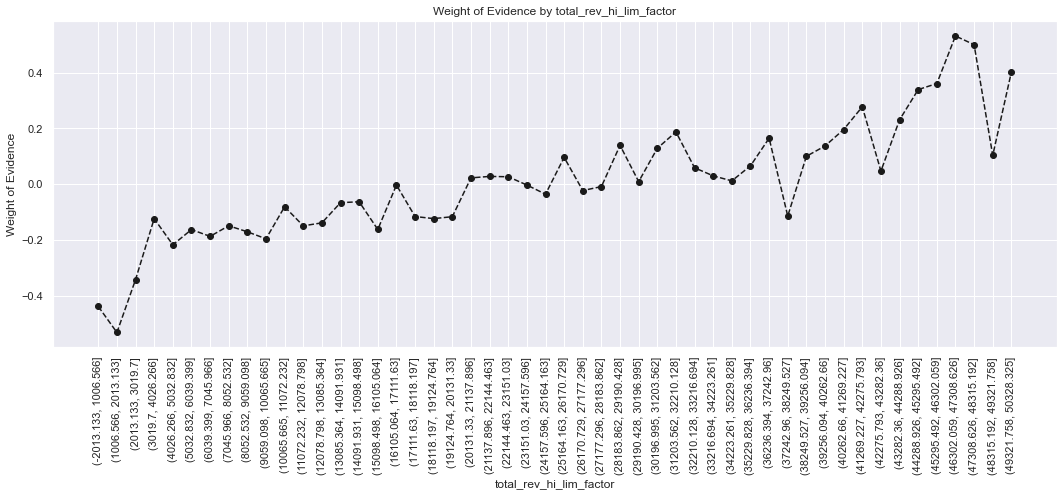

In [81]:
# total_rev_hi_lim
df_inputs_prepr['total_rev_hi_lim_factor'] = pd.cut(df_inputs_prepr['total_rev_hi_lim'], 2000)
# Here we do fine-classing: using the 'cut' method, we split the variable into 2000 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'total_rev_hi_lim_factor', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp.iloc[: 50, : ], 90)

In [82]:
# Categories
# '<=5K', '5K-10K', '10K-20K', '20K-30K', '30K-40K', '40K-55K', '55K-95K', '>95K'
df_inputs_prepr['total_rev_hi_lim:<=5K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] <= 5000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:5K-10K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 5000) &
                                                      (df_inputs_prepr['total_rev_hi_lim'] <= 10000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:10K-20K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 10000) & 
                                                       (df_inputs_prepr['total_rev_hi_lim'] <= 20000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:20K-30K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 20000) &
                                                       (df_inputs_prepr['total_rev_hi_lim'] <= 30000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:30K-40K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 30000) & 
                                                       (df_inputs_prepr['total_rev_hi_lim'] <= 40000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:40K-55K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 40000) &
                                                       (df_inputs_prepr['total_rev_hi_lim'] <= 55000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:55K-95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 55000) & 
                                                       (df_inputs_prepr['total_rev_hi_lim'] <= 95000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:>95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 95000), 1, 0)

<h4><a id="installment_factor_woe">8.2.14 Installment Factor</a></h4>

[Top](#continuouswoe)

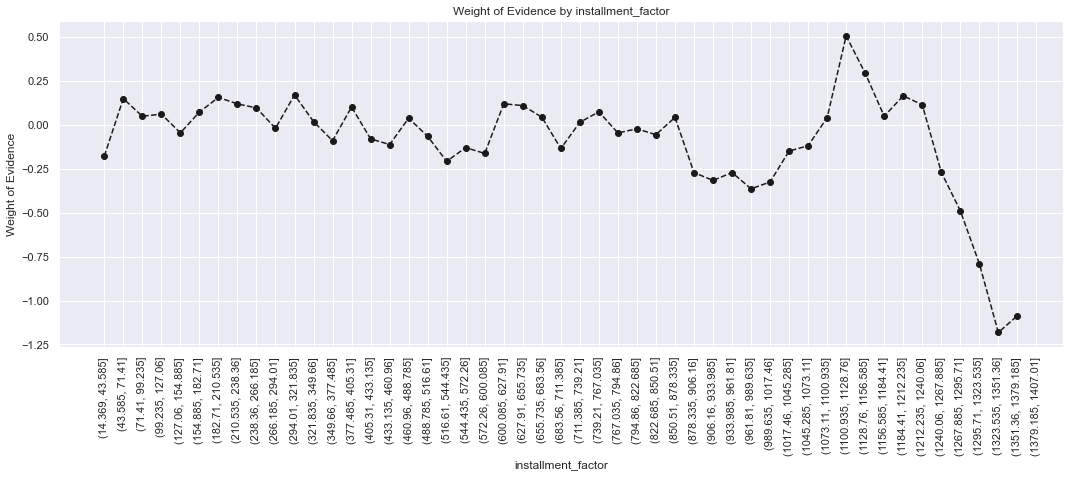

In [83]:
# installment
df_inputs_prepr['installment_factor'] = pd.cut(df_inputs_prepr['installment'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'installment_factor', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

<h4><a id="annual_inc_factor_woe">8.2.15 Annual Income</a></h4>

[Top](#continuouswoe)

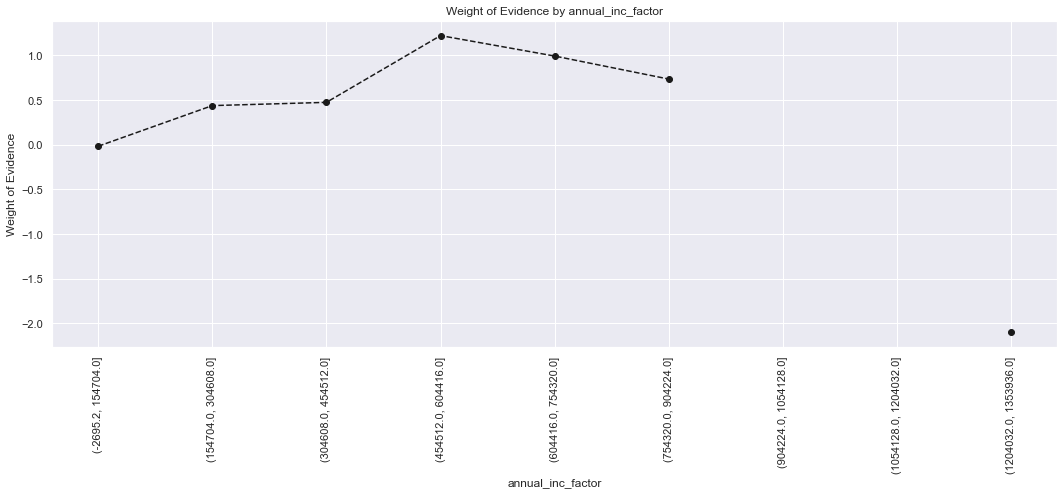

In [84]:
# annual_inc
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'annual_inc_factor', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [85]:
# Initial examination shows that there are too few individuals with large income and too many with small income.
# Hence, we are going to have one category for more than 150K, and we are going to apply our approach to determine
# the categories of everyone with 140k or less.
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['annual_inc'] <= 140000, : ]
#loan_data_temp = loan_data_temp.reset_index(drop = True)
#df_inputs_prepr_temp

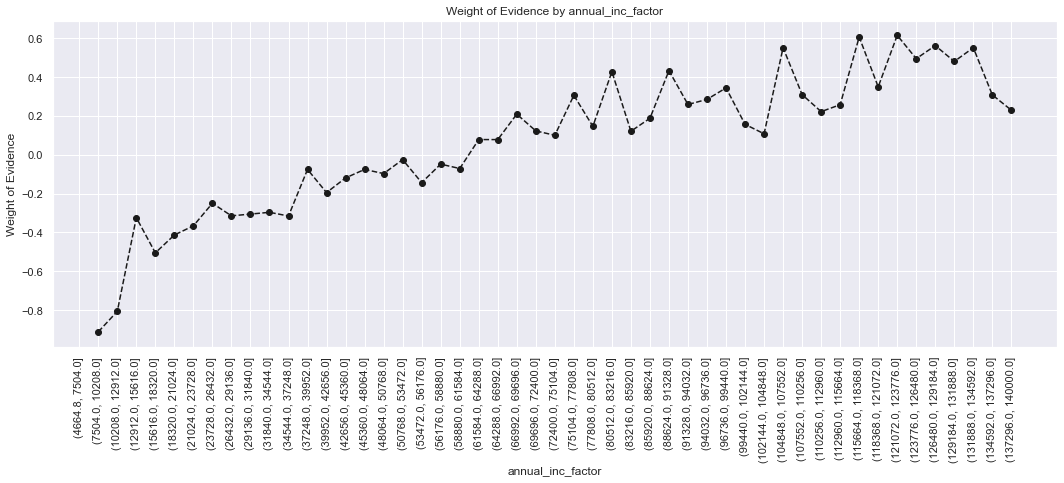

In [86]:
df_inputs_prepr_temp["annual_inc_factor"] = pd.cut(df_inputs_prepr_temp['annual_inc'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'annual_inc_factor', df_targets_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [87]:
# WoE is monotonically decreasing with income, so we split income in 10 equal categories, each with width of 15k.
df_inputs_prepr['annual_inc:<20K'] = np.where((df_inputs_prepr['annual_inc'] <= 20000), 1, 0)
df_inputs_prepr['annual_inc:20K-30K'] = np.where((df_inputs_prepr['annual_inc'] > 20000) & 
                                                 (df_inputs_prepr['annual_inc'] <= 30000), 1, 0)
df_inputs_prepr['annual_inc:30K-40K'] = np.where((df_inputs_prepr['annual_inc'] > 30000) &
                                                 (df_inputs_prepr['annual_inc'] <= 40000), 1, 0)
df_inputs_prepr['annual_inc:40K-50K'] = np.where((df_inputs_prepr['annual_inc'] > 40000) &
                                                 (df_inputs_prepr['annual_inc'] <= 50000), 1, 0)
df_inputs_prepr['annual_inc:50K-60K'] = np.where((df_inputs_prepr['annual_inc'] > 50000) &
                                                 (df_inputs_prepr['annual_inc'] <= 60000), 1, 0)
df_inputs_prepr['annual_inc:60K-70K'] = np.where((df_inputs_prepr['annual_inc'] > 60000) &
                                                 (df_inputs_prepr['annual_inc'] <= 70000), 1, 0)
df_inputs_prepr['annual_inc:70K-80K'] = np.where((df_inputs_prepr['annual_inc'] > 70000) & 
                                                 (df_inputs_prepr['annual_inc'] <= 80000), 1, 0)
df_inputs_prepr['annual_inc:80K-90K'] = np.where((df_inputs_prepr['annual_inc'] > 80000) &
                                                 (df_inputs_prepr['annual_inc'] <= 90000), 1, 0)
df_inputs_prepr['annual_inc:90K-100K'] = np.where((df_inputs_prepr['annual_inc'] > 90000) & 
                                                  (df_inputs_prepr['annual_inc'] <= 100000), 1, 0)
df_inputs_prepr['annual_inc:100K-120K'] = np.where((df_inputs_prepr['annual_inc'] > 100000) &
                                                   (df_inputs_prepr['annual_inc'] <= 120000), 1, 0)
df_inputs_prepr['annual_inc:120K-140K'] = np.where((df_inputs_prepr['annual_inc'] > 120000) & 
                                                   (df_inputs_prepr['annual_inc'] <= 140000), 1, 0)
df_inputs_prepr['annual_inc:>140K'] = np.where((df_inputs_prepr['annual_inc'] > 140000), 1, 0)

<h4><a id="mths_since_last_delinq_woe">8.2.16 Months Since Last Delinquency</a></h4>

[Top](#continuouswoe)

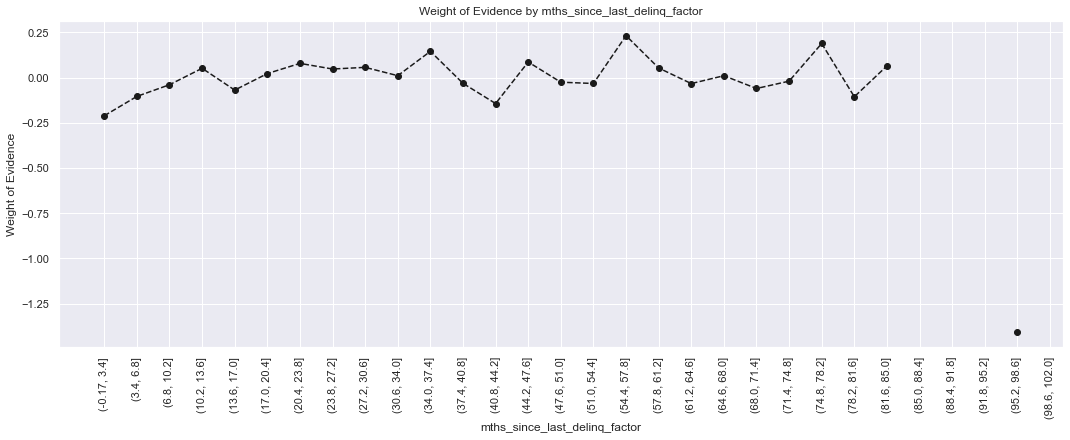

In [88]:
# mths_since_last_delinq
# We have to create one category for missing values and do fine and coarse classing for the rest.
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_delinq'])]
df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'mths_since_last_delinq_factor', df_targets_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [89]:
# Categories: Missing, 0-3, 4-30, 31-56, >=57
df_inputs_prepr['mths_since_last_delinq:Missing'] = np.where((df_inputs_prepr['mths_since_last_delinq'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_delinq:0-3'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 0) &
                                                         (df_inputs_prepr['mths_since_last_delinq'] <= 3), 1, 0)
df_inputs_prepr['mths_since_last_delinq:4-30'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 4) & 
                                                          (df_inputs_prepr['mths_since_last_delinq'] <= 30), 1, 0)
df_inputs_prepr['mths_since_last_delinq:31-56'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 31) &
                                                           (df_inputs_prepr['mths_since_last_delinq'] <= 56), 1, 0)
df_inputs_prepr['mths_since_last_delinq:>=57'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 57), 1, 0)

<h4><a id="dti_factor_woe">8.2.17 Debt to Income Ratio</a></h4>

[Top](#continuouswoe)

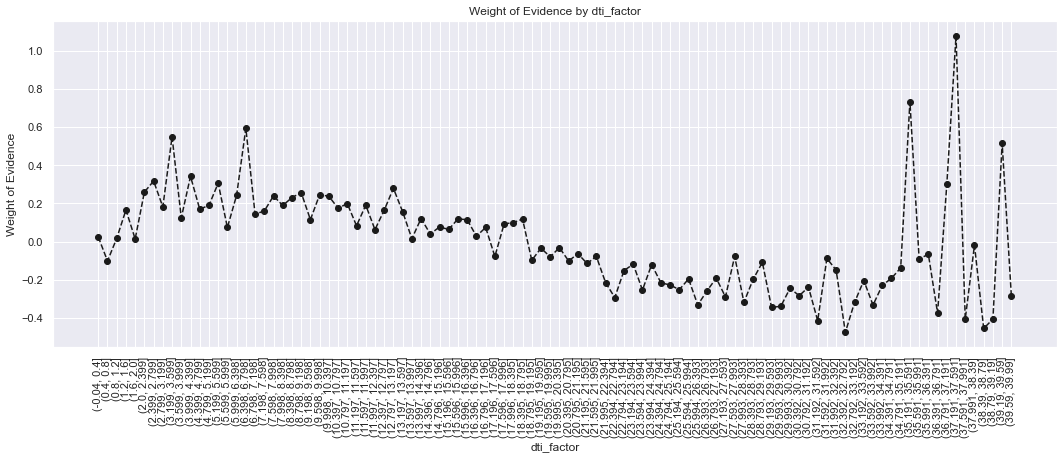

In [90]:
# dti
df_inputs_prepr['dti_factor'] = pd.cut(df_inputs_prepr['dti'], 100)
# Here we do fine-classing: using the 'cut' method, we split the variable into 100 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'dti_factor', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [91]:
# Similarly to income, initial examination shows that most values are lower than 200.
# Hence, we are going to have one category for more than 35, and we are going to apply our approach to determine
# the categories of everyone with 150k or less.
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['dti'] <= 35, : ]

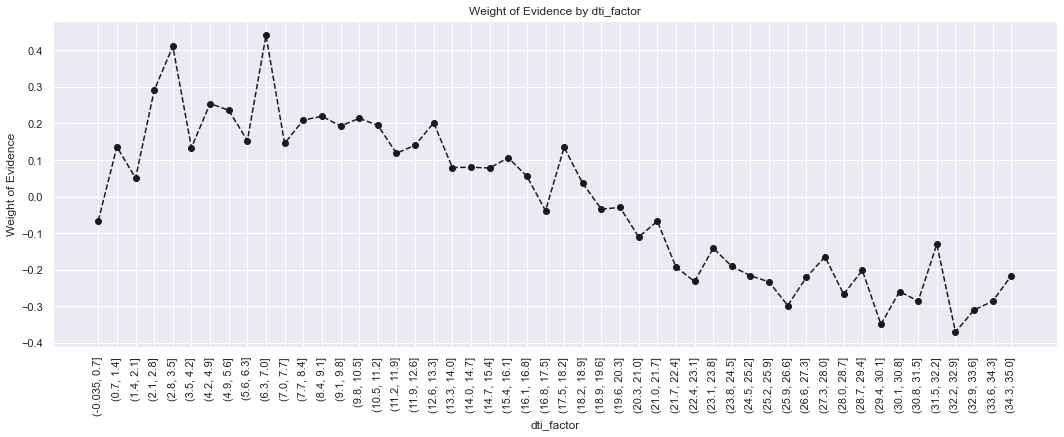

In [92]:
df_inputs_prepr_temp['dti_factor'] = pd.cut(df_inputs_prepr_temp['dti'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'dti_factor', df_targets_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [93]:
# Categories:
df_inputs_prepr['dti:<=1.4'] = np.where((df_inputs_prepr['dti'] <= 1.4), 1, 0)
df_inputs_prepr['dti:1.4-3.5'] = np.where((df_inputs_prepr['dti'] > 1.4) & (df_inputs_prepr['dti'] <= 3.5), 1, 0)
df_inputs_prepr['dti:3.5-7.7'] = np.where((df_inputs_prepr['dti'] > 3.5) & (df_inputs_prepr['dti'] <= 7.7), 1, 0)
df_inputs_prepr['dti:7.7-10.5'] = np.where((df_inputs_prepr['dti'] > 7.7) & (df_inputs_prepr['dti'] <= 10.5), 1, 0)
df_inputs_prepr['dti:10.5-16.1'] = np.where((df_inputs_prepr['dti'] > 10.5) & (df_inputs_prepr['dti'] <= 16.1), 1, 0)
df_inputs_prepr['dti:16.1-20.3'] = np.where((df_inputs_prepr['dti'] > 16.1) & (df_inputs_prepr['dti'] <= 20.3), 1, 0)
df_inputs_prepr['dti:20.3-21.7'] = np.where((df_inputs_prepr['dti'] > 20.3) & (df_inputs_prepr['dti'] <= 21.7), 1, 0)
df_inputs_prepr['dti:21.7-22.4'] = np.where((df_inputs_prepr['dti'] > 21.7) & (df_inputs_prepr['dti'] <= 22.4), 1, 0)
df_inputs_prepr['dti:22.4-35'] = np.where((df_inputs_prepr['dti'] > 22.4) & (df_inputs_prepr['dti'] <= 35), 1, 0)
df_inputs_prepr['dti:>35'] = np.where((df_inputs_prepr['dti'] > 35), 1, 0)

<h4><a id="mths_since_last_record_woe">8.2.18 Months Since Last Record</a></h4>

[Top](#continuouswoe)

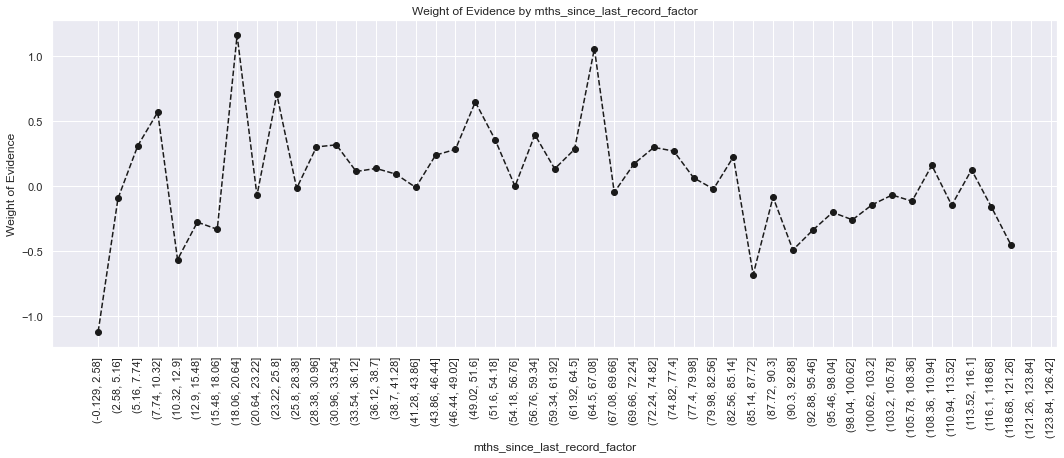

In [94]:
# mths_since_last_record
# We have to create one category for missing values and do fine and coarse classing for the rest.
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_record'])]
#sum(loan_data_temp['mths_since_last_record'].isnull())
df_inputs_prepr_temp['mths_since_last_record_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_record'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'mths_since_last_record_factor', 
                                 df_targets_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)

In [95]:
# Categories: 'Missing', '0-2', '3-20', '21-31', '32-80', '81-86', '>86'
df_inputs_prepr['mths_since_last_record:Missing'] = np.where((df_inputs_prepr['mths_since_last_record'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_record:0-2'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 0) & 
                                                         (df_inputs_prepr['mths_since_last_record'] <= 2), 1, 0)
df_inputs_prepr['mths_since_last_record:3-20'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 3) &
                                                          (df_inputs_prepr['mths_since_last_record'] <= 20), 1, 0)
df_inputs_prepr['mths_since_last_record:21-31'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 21) & 
                                                           (df_inputs_prepr['mths_since_last_record'] <= 31), 1, 0)
df_inputs_prepr['mths_since_last_record:32-80'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 32) &
                                                           (df_inputs_prepr['mths_since_last_record'] <= 80), 1, 0)
df_inputs_prepr['mths_since_last_record:81-86'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 81) & 
                                                           (df_inputs_prepr['mths_since_last_record'] <= 86), 1, 0)
df_inputs_prepr['mths_since_last_record:>86'] = np.where((df_inputs_prepr['mths_since_last_record'] > 86), 1, 0)

<h2><a id="exportdata">9. Export to CSV File</a></h2>

[Index](#index)

In [96]:
#####
loan_data_inputs_train = df_inputs_prepr

In [97]:
loan_data_inputs_train.to_csv('../Data/loan_data_inputs_test.csv')
loan_data_targets_train.to_csv('../Data/loan_data_targets_test.csv')